In [ ]:
# import libraries
import numpy as np
import sympy as sp
from numpy.linalg import svd
import matplotlib.pyplot as plt
from PIL import Image

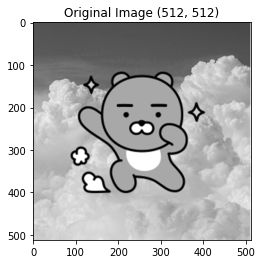

In [ ]:
N = 512
image = Image.open("/content/drive/MyDrive/Colab Notebooks/영상처리/datas/cloudRyan.png").resize((N, N)).convert('L')
original_f = np.array(image)
plt.imshow(original_f, cmap="gray", vmin=0, vmax=255 )
plt.title("Original Image " + str(original_f.shape))
plt.show()  # 이미지 출력

In [ ]:
# GetKxKs : NxN image to 8x8 (K=8) sub images
def GetKxKs(image, K=8):
  n = len(image)
  if n % K != 0: return
  ret = []
  for row in range(int(n/K)): 
    for col in range(int(n/K)):
      ret.append(image[row*K:(row+1)*K, col*K:(col+1)*K])
  return np.array(ret)

# GetNxN : KxK(8x8) sub images to NxN image
def GetNxN(images):
  K = images.shape[1]
  N = int(np.sqrt(images.shape[0]) * K)
  ret_image = np.empty((N, N), float)
  for i in range(N):
    for j in range(N):
      group = int(i/K) * int(N/K) + int(j/K)
      ret_image[i][j] = images[group][i%K][j%K]
  return np.array(ret_image)

In [ ]:
# partition to 8*8 sub images
f_s = GetKxKs(original_f, 8)
print("8*8 서브 이미지들을 담은 f_s :", f_s.shape)

In [ ]:
# Cosine Fourier Formular
def CosineFourier(N, m, n):
  if m == 0: c = 1/np.sqrt(2)
  else: c = 1
  return np.sqrt(2/N) * c * np.cos((2*n+1) * m * np.pi/(2*N))

# DCT (Discrete Cosine Transform)
def DCT(N):
  U = []
  for i in range(N):
    row = []
    for j in range(N):
      row.append(CosineFourier(N, j, i))
    U.append(row)
  return np.array(U)

In [ ]:
# Ds : The 8*8 image D list (Discrete Cosine Fourier Transformed matrix)
Ds = []
D8 = DCT(8)
for f in f_s:
  Ds.append(np.dot(D8, np.dot(f, D8)))  # D8 = D8.T
Ds = np.array(Ds)

In [ ]:
# Upper Left Triangular region
def UpperLeft(matrix):
  N = len(matrix)
  ret = np.zeros(shape=(N,N), dtype=np.float128)
  for i in range(N):
    for j in range(N):
      if i >= j:
        ret[i][j] = matrix[i][j]
  return ret

In [ ]:
# UpperLeft를 구한다. 
LDs = []
for D in Ds:
  LDs.append(UpperLeft(D))
#  LDs.append(D)

In [ ]:
# Spatial Domain으로 변환한다. 
ILDs = []
for LD in LDs:
  ILDs.append(np.dot(np.linalg.inv(D8), np.dot(LD, np.linalg.inv(D8))))
ILDs = np.array(ILDs)

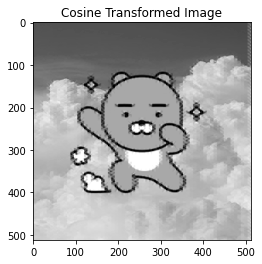

In [ ]:
# 그림을 그려준다. 
plt.imshow(GetNxN(ILDs), cmap='gray', vmin=0, vmax=255 )
plt.title("Cosine Transformed Image")
plt.show()

In [ ]:
# SVD 함수를 만들어 준다. 
def SVD(g, n=4):
  A = np.array(g).astype(np.float64)
  U, s, V = np.linalg.svd(A)
  S = np.zeros(A.shape)
  S_sorted = np.sort(s)[::-1]
  for i in range(len(S)):
#    if s[i] >= S_sorted[n-1]:  # eigen value 중 n번째 이상의 값만 필터링
    if i < n:
      S[i][i] = s[i]
  return np.dot(U, np.dot(S, V))

In [ ]:
# Ss : The 8*8 image SVD list (SVD Transformed matrix)
Ss = []
for f in f_s:
  Ss.append(SVD(f, 4))
Ss = np.array(Ss)

plt.imshow(GetNxN(Ss), cmap='gray', vmin=0, vmax=255) 
plt.title("SVD Image")
plt.show()

In [ ]:
def Flatten(gs):
  ret = []
  K, M, N = gs.shape
  for g in gs:
    ret.append(g.T)
  return np.array(ret).reshape(K, M*N, 1)

def Shorten(images):
  M, N, _ = images.shape
  n = int(np.sqrt(N))
  ret = []
  for m in range(M):
    temp = np.zeros(shape=(n, n))
    for i in range(N):
      temp[i%n][int(i/n)] = images[m][i][0]
    ret.append(temp)
  return np.array(ret)

In [ ]:
# Autocorrelation
def R(g):
  N, _ = g.shape
  R = []
  for term in range(N):  # term = 0 to 15
    tempR = 0
    for i in range(N):
      tempR += (g[i][0] * g[(i+term)%N][0])
    R.append(tempR/N)
  return np.array(R)

  # Autocovariance Matrix
def C(g):
  ret = []
  autocov = (R(g) - np.mean(g)**2)
  N = autocov.shape[0]
  for crit in range(N):
    ret.append(np.concatenate((autocov[-crit:], autocov[:-crit]), axis=None))
  return np.array(ret)

def KLT(gs, n):
  ret = []
  for g in gs:
    U, s, V = np.linalg.svd(C(g))
    for i in range(s.shape[0]):
      if i >= n:
        U[i] *= 0
    temp = np.dot(U.T, g-np.mean(g)) + np.mean(g)
    temp[temp<0] = 0
    ret.append(temp)
  return np.array(ret)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  


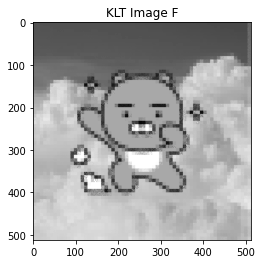

In [ ]:
# Ks : THe 8*8 images KLT list (KLT Transformed matrix)
Ks = Shorten(KLT(Flatten(f_s), 4))

# Get KLT image directly
plt.imshow(GetNxN(Ks), cmap='gray', vmin=0, vmax=255)
plt.title("KLT Image F")
plt.show()